Data Loading

In [93]:
import pandas as pd

tracking_data = pd.read_csv("tracking_data.csv")
tracking = pd.read_csv("tracking.csv")

In [94]:
tracking_data = tracking_data.sort_values(by='FRAME').reset_index(drop=True)

In [95]:
tracking_data.head()

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y
0,105690,60,28437,28437,True,8.07,-16.70
1,105690,60,16471,16471,True,5.77,-6.10
2,105690,60,55,55,True,0.38,-1.03
3,105690,60,28435,28435,True,3.18,1.56
4,105690,60,28566,28566,False,4.48,3.15


In [96]:
tracking.head()

,MATCH_ID,FRAME,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,IMAGE_CORNERS_PROJECTION,TIMESTAMP,PERIOD
0,105690,0,NaN,NaN,[],NaN,NaN
1,105690,1,NaN,NaN,"[-39.64771619718988,39,-15.330777205830284,-39...",NaN,NaN
2,105690,2,NaN,NaN,"[-39.53509099528044,39,-15.02475615465837,-39....",NaN,NaN
3,105690,3,NaN,NaN,"[-38.87446954611893,39,-15.3418580847785,-39.9...",NaN,NaN
4,105690,4,NaN,NaN,"[-39.02694398852428,39,-15.241715150701653,-39...",NaN,NaN


Lösche Daten zu denen es keine korrespondierenden tracking_data gibt. Wir wollen nur echte Spielzeitpunkte analysieren.

In [97]:
valide_frames = tracking_data['FRAME'].unique()
tracking = tracking[tracking['FRAME'].isin(valide_frames)]

In [98]:
tracking['POSSESSION_TRACKABLE_OBJECT'] = tracking['POSSESSION_TRACKABLE_OBJECT'].astype('Int64')

Konvertiere in Datentyp, der Zeit unterstützt.

In [99]:
tracking['TIME_DELTA'] = pd.to_timedelta(tracking['TIMESTAMP'])

Finde Anpfiffzeitpunkt. (Frame Nummer des Anpfiffs)

In [100]:
anpfiff_time = pd.to_timedelta("0:00:00")
anpfiff_frame = tracking.loc[tracking['TIME_DELTA'] >= anpfiff_time, 'FRAME'].min()

In [101]:
tracking_data[tracking_data["FRAME"] == anpfiff_frame]

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y
0,105690,60,28437,28437,True,8.07,-16.70
1,105690,60,16471,16471,True,5.77,-6.10
2,105690,60,55,55,True,0.38,-1.03
3,105690,60,28435,28435,True,3.18,1.56
4,105690,60,28566,28566,False,4.48,3.15
5,105690,60,29957,29957,True,-0.88,-10.55
6,105690,60,29926,29926,True,-0.53,-19.85
7,105690,60,61575,61575,True,-0.78,11.75
8,105690,60,28555,28555,False,-10.90,1.54
9,105690,60,39023,39023,True,-0.76,30.01


In [102]:
start_spieler = tracking_data[
    (tracking_data["FRAME"] == anpfiff_frame) &
    (tracking_data["TRACK_ID"] != 55)
]

In [103]:
len(tracking_data['TRACKABLE_OBJECT'].unique())

30

Insgesamt spielen 30 "Objekte" mit, d.h. es gibt insgesamt vermutlich 7 Auswechsunglen

## Zuordnung der Spieler zu Teams

Variante 1: Spielerposition bei Antoss

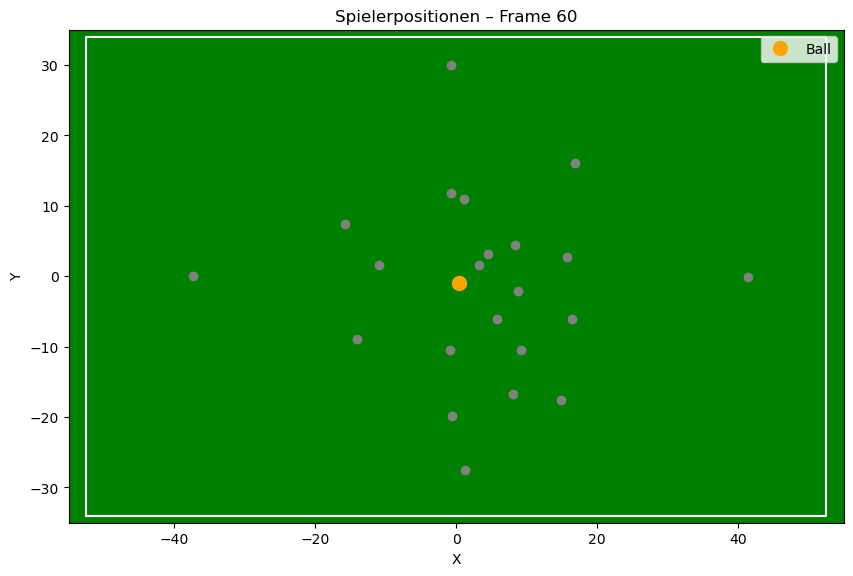

In [104]:
import matplotlib.pyplot as plt

def plot_spieler(tracking_df, frame, team0_ids=None, team1_ids=None, ball_id=55):
    df = tracking_df[tracking_df['FRAME'] == frame]

    fig, ax = plt.subplots(figsize=(10, 7))

    # Spielfeld zeichnen (vereinfachtes Rechteck)
    ax.set_facecolor('green')
    plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")

    ax.set_xlim(-55, 55)
    ax.set_ylim(-35, 35)
    ax.set_aspect('equal')

    # Flags, um Label nur einmal hinzuzufügen
    ball_plotted = False
    team0_plotted = False
    team1_plotted = False

    for _, row in df.iterrows():
        if row['TRACK_ID'] == ball_id:
            if not ball_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10, label='Ball')
                ball_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='orange', markersize=10)
        elif team0_ids and row['TRACK_ID'] in team0_ids:
            if not team0_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='blue', label='Auswärts')
                team0_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='blue')
        elif team1_ids and row['TRACK_ID'] in team1_ids:
            if not team1_plotted:
                ax.plot(row['X'], row['Y'], 'o', color='red', label='Heim')
                team1_plotted = True
            else:
                ax.plot(row['X'], row['Y'], 'o', color='red')
        else:
            ax.plot(row['X'], row['Y'], 'o', color='gray')

    plt.title(f"Spielerpositionen – Frame {frame}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc='upper right')
    plt.show()


plot_spieler(tracking_data, anpfiff_frame)

In [105]:
tracking_data[(tracking_data["FRAME"] == anpfiff_frame) & (tracking_data['X'] > 0)].shape

(15, 7)

Variante 2: Nehme tracking und setze Team zu Ballbesitz Team und Trackable object

In [106]:
import pandas as pd

ballbesitz = tracking[tracking['POSSESSION_TRACKABLE_OBJECT'].notna()]

spieler_team_df = ballbesitz[['POSSESSION_TRACKABLE_OBJECT', 'POSSESSION_GROUP']].drop_duplicates()

spieler_team_map = spieler_team_df.groupby('POSSESSION_TRACKABLE_OBJECT')['POSSESSION_GROUP'].agg(lambda x: x.mode())

In [107]:
away_team_ids = spieler_team_map[spieler_team_map == "away team"].index.tolist()
home_team_ids = spieler_team_map[spieler_team_map == "home team"].index.tolist()

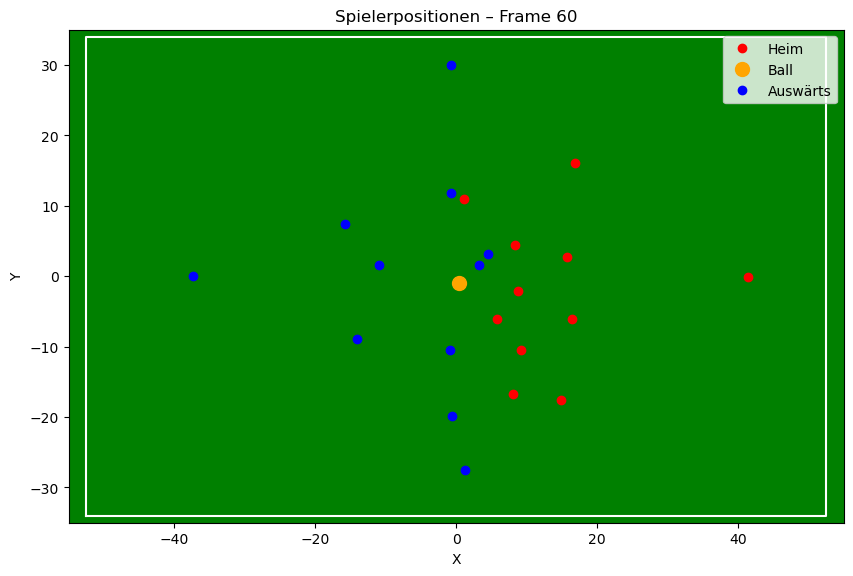

In [108]:
plot_spieler(tracking_data, anpfiff_frame, team0_ids=away_team_ids, team1_ids=home_team_ids)

Wir wissen nun, das Heimteam spielt in der ersten Halbzeit von rechts nach links.

In [109]:
halbzeit_frame = tracking[tracking['TIMESTAMP'] == "00:45:00"]['FRAME'].iloc[1]

In [110]:
halbzeit_frame

27690

In [111]:
tracking[tracking["FRAME"] == halbzeit_frame]

,MATCH_ID,FRAME,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,IMAGE_CORNERS_PROJECTION,TIMESTAMP,PERIOD,TIME_DELTA
27690,105690,27690,away team,<NA>,[],00:45:00,2.0,0 days 00:45:00


## Bewegungsprofile

In [112]:
tracking_data_full = tracking_data.merge(tracking[['FRAME', 'PERIOD', 'POSSESSION_GROUP', 'POSSESSION_TRACKABLE_OBJECT' ,'TIMESTAMP', 'TIME_DELTA']], on='FRAME', how='left')

In [113]:
tracking_data_full

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA
0,105690,60,28437,28437,True,8.07,-16.70,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
1,105690,60,16471,16471,True,5.77,-6.10,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
3,105690,60,28435,28435,True,3.18,1.56,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
4,105690,60,28566,28566,False,4.48,3.15,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1108641,105690,57452,29938,29938,True,-45.21,-3.02,2.0,NaN,<NA>,01:34:36.2,0 days 01:34:36.200000
1108642,105690,57452,28566,28566,True,-43.22,-7.84,2.0,NaN,<NA>,01:34:36.2,0 days 01:34:36.200000
1108643,105690,57452,28435,28435,True,-40.93,-10.89,2.0,NaN,<NA>,01:34:36.2,0 days 01:34:36.200000
1108644,105690,57452,55,55,False,-28.78,-2.31,2.0,NaN,<NA>,01:34:36.2,0 days 01:34:36.200000


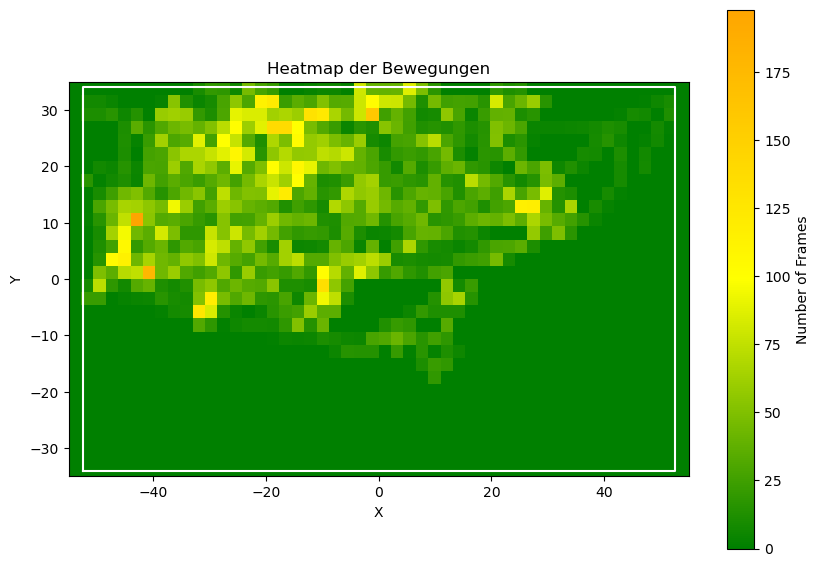

In [114]:
from matplotlib.colors import LinearSegmentedColormap

green_red_cmap = LinearSegmentedColormap.from_list("green_red", ["green", "yellow", "orange"])

plt.figure(figsize=(10, 7))
plt.title("Heatmap der Bewegungen")

plt.plot([-52.5, 52.5, 52.5, -52.5, -52.5], [-34, -34, 34, 34, -34], color="white")
plt.xlim(-55, 55)
plt.ylim(-35, 35)
plt.gca().set_facecolor("green")

plt.hist2d(
    ball['X'],
    ball['Y'],
    bins=[50, 30],           # Anzahl der Bins in X und Y (quadratisch = gleiche Zahl)
    range=[[-55, 55], [-35, 35]],  # Spielfeldgrenzen
    cmap=green_red_cmap
)
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal')
plt.colorbar(label='Number of Frames')
plt.show()

## Tor erkennen

In [115]:
tracking_ball = tracking_data_full[tracking_data_full['TRACK_ID'] == 55].copy()

In [116]:
tracking_ball[(tracking_ball['IS_VISIBLE'] == True) & (tracking_ball['X'] < 53) & (tracking_ball['X'] > 51.5) & (tracking_ball['Y'] < 5) & (tracking_ball['Y'] > -5)]

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA
736875,105690,37527,55,55,True,52.00,2.45,2.0,home team,<NA>,01:01:23.7,0 days 01:01:23.700000
736898,105690,37528,55,55,True,52.57,2.61,2.0,home team,<NA>,01:01:23.8,0 days 01:01:23.800000


In [117]:
tracking_ball[(tracking_ball['IS_VISIBLE'] == True) & (tracking_ball['X'] > -53) & (tracking_ball['X'] < -51.5) & (tracking_ball['Y'] < 5) & (tracking_ball['Y'] > -5)]

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA
271217,105690,13663,55,55,True,-51.86,1.49,1.0,home team,<NA>,00:22:40.3,0 days 00:22:40.300000
271246,105690,13664,55,55,True,-52.51,2.05,1.0,home team,<NA>,00:22:40.4,0 days 00:22:40.400000
354086,105690,17881,55,55,True,-51.55,4.12,1.0,away team,<NA>,00:29:42.1,0 days 00:29:42.100000
354109,105690,17882,55,55,True,-51.61,4.44,1.0,away team,<NA>,00:29:42.2,0 days 00:29:42.200000
354132,105690,17883,55,55,True,-51.80,4.68,1.0,away team,<NA>,00:29:42.3,0 days 00:29:42.300000
354154,105690,17884,55,55,True,-51.88,4.77,1.0,away team,<NA>,00:29:42.4,0 days 00:29:42.400000
354177,105690,17885,55,55,True,-51.88,4.81,1.0,away team,<NA>,00:29:42.5,0 days 00:29:42.500000
354201,105690,17886,55,55,True,-51.74,4.88,1.0,away team,<NA>,00:29:42.6,0 days 00:29:42.600000
354224,105690,17887,55,55,True,-51.64,4.93,1.0,away team,<NA>,00:29:42.7,0 days 00:29:42.700000
354247,105690,17888,55,55,True,-51.70,4.86,1.0,away team,<NA>,00:29:42.8,0 days 00:29:42.800000


Es erscheint nur plausibel, dass ein Tor zwischen Frames 19677 und 19711 gefallen ist, da hier der Ball im Tor liegen bleibt und der Ball sichtbar ist für die Kameras.  
Allerdings ist danach kein Anstoß zu erkennen, das Spiel läuft normal weiter. 

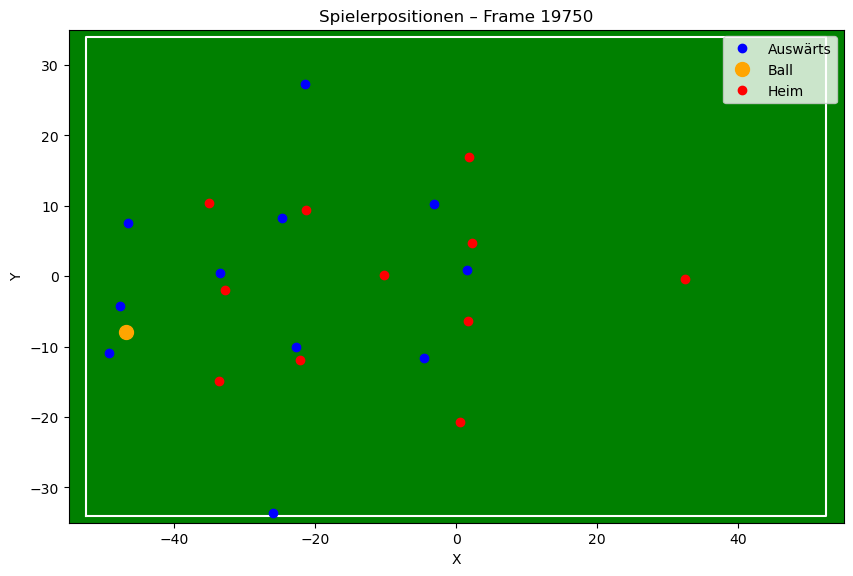

In [118]:
plot_spieler(tracking_data, 19750, away_team_ids, home_team_ids)

## Alternative: Anstoß erkennen

Die Spielunterbrechung muss länger als eine Minute sein und der Ball muss in den 10 Sekunden davor im Tor gelandet sein und in den 10 Sekunden danach im Mittelkreis liegen.

In [119]:
tracking_ball['TIME_DIFF'] = tracking_ball['TIME_DELTA'].diff()

In [120]:
tracking_ball[tracking_ball['TIME_DIFF'] >= "00:00:30.0"]

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA,TIME_DIFF
90942,105690,4769,55,55,False,-8.35,-27.51,1.0,NaN,<NA>,00:07:50.9,0 days 00:07:50.900000,0 days 00:00:49.800000
302688,105690,15483,55,55,False,-52.13,-19.99,1.0,NaN,<NA>,00:25:42.3,0 days 00:25:42.300000,0 days 00:00:33.900000
485328,105690,24903,55,55,False,-7.85,6.89,1.0,NaN,<NA>,00:41:24.3,0 days 00:41:24.300000,0 days 00:00:38.500000
738277,105690,38160,55,55,False,-6.46,28.29,2.0,NaN,<NA>,01:02:27,0 days 01:02:27,0 days 00:00:57.300000
888674,105690,46255,55,55,False,-21.32,-24.54,2.0,NaN,<NA>,01:15:56.5,0 days 01:15:56.500000,0 days 00:01:13.800000
1078061,105690,56123,55,55,False,6.63,12.25,2.0,NaN,<NA>,01:32:23.3,0 days 01:32:23.300000,0 days 00:00:31.800000


Der Ball muss in der Mitte liegen und in einem der letzten 500 Frames im Tor gelegen haben

In [121]:
tracking_ball['is_center'] = (tracking_ball['X'].abs() < 1.5) & (tracking_ball['Y'].abs() < 1.5)

tracking_ball['is_goal_zone'] = (
    ((ball['X'] > 51) & (tracking_ball['X'] < 53) | (tracking_ball['X'] < -51) & (tracking_ball['X'] > -53)) &
    (ball['Y'].abs() < 5)
)

tracking_ball['goal_in_last_600'] = (
    tracking_ball['is_goal_zone']
    .rolling(window=600, min_periods=1)
    .max()  # True, wenn mindestens 1x True in diesem Fenster war
)

result = tracking_ball[tracking_ball['is_center'] & tracking_ball['goal_in_last_600']]
result

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA,TIME_DIFF,is_center,is_goal_zone,goal_in_last_600


In [122]:
tracking_data_full

,MATCH_ID,FRAME,TRACK_ID,TRACKABLE_OBJECT,IS_VISIBLE,X,Y,PERIOD,POSSESSION_GROUP,POSSESSION_TRACKABLE_OBJECT,TIMESTAMP,TIME_DELTA
0,105690,60,28437,28437,True,8.07,-16.70,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
1,105690,60,16471,16471,True,5.77,-6.10,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
2,105690,60,55,55,True,0.38,-1.03,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
3,105690,60,28435,28435,True,3.18,1.56,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
4,105690,60,28566,28566,False,4.48,3.15,1.0,NaN,<NA>,00:00:00,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1108641,105690,57452,29938,29938,True,-45.21,-3.02,2.0,NaN,<NA>,01:34:36.2,0 days 01:34:36.200000
1108642,105690,57452,28566,28566,True,-43.22,-7.84,2.0,NaN,<NA>,01:34:36.2,0 days 01:34:36.200000
1108643,105690,57452,28435,28435,True,-40.93,-10.89,2.0,NaN,<NA>,01:34:36.2,0 days 01:34:36.200000
1108644,105690,57452,55,55,False,-28.78,-2.31,2.0,NaN,<NA>,01:34:36.2,0 days 01:34:36.200000


In [123]:
import pickle
tracking_data_full.to_pickle('tracking_data_full.pkl')
tracking_data.to_pickle('tracking_data.pkl')
tracking.to_pickle('tracking.pkl')